# AIT Development notebook


## notebook of structure

|#|area name|cell num|description|edit or not|
|---|---|---|---|---|
| 1|flags set|1|setting of launch jupyter or ait flag.|no edit|
| 2|ait-sdk install|1|Use only jupyter launch.<br>find ait-sdk and install.|no edit|
| 3|create requirements and pip install|3|Use only jupyter launch.<br>create requirements.txt.<br>And install by requirements.txt.|should edit(second cell, you set use modules.)|
| 4|import|2|you should write use import modules.<br>but bottom lines do not edit.|should edit(first cell, you import your moduel.)|
| 5|create manifest|1|Use only jupyter launch.<br>create ait.manifest.json.|should edit|
| 6|create input|1|Use only jupyter launch.<br>create ait.input.json.|should edit|
| 7|initialize|1|this cell is initialize for ait progress.|no edit|
| 8|functions|N|you defined measures, resources, downloads in ait.manifesit.json. <br>Define any functions to add these.|should edit|
| 9|main|1|Read the data set or model and calls the function defined in `functions-area`.|should edit|
|10|entrypoint|1|Call the main function.|no edit|
|11|license attribute set|1|Use only notebook launch.<br>Setting attribute for license.|should edit|
|12|prepare deploy|1|Use only notebook launch.<br>Convert to python programs and create dag.py.|no edit|

## notebook template revision history

### 1.0.1 2020/10/21

* add revision history
* separate `create requirements and pip install` editable and noeditable
* separate `import` editable and noeditable

### 1.0.0 2020/10/12

* new cerarion

In [ ]:
#########################################
# area:flags set
# do not edit
#########################################

# Determine whether to start AIT or jupyter by startup argument
import sys
is_ait_launch = (len(sys.argv) == 2)

In [2]:
#########################################
# area:ait-sdk install
# do not edit
#########################################
if not is_ait_launch:
    # get ait-sdk file name
    from glob import glob
    import os

    current_dir = %pwd

    ait_sdk_path = "./ait_sdk-*-py3-none-any.whl"
    ait_sdk_list = glob(ait_sdk_path)
    ait_sdk_name = os.path.basename(ait_sdk_list[-1])

    # install ait-sdk
    !pip install --upgrade pip
    !pip install -q --no-deps --force-reinstall ./$ait_sdk_name

In [3]:
#########################################
# area:create requirements and pip install
# do not edit
#########################################
if not is_ait_launch:
    from ait_sdk.common.files.ait_requirements_generator import AITRequirementsGenerator
    requirements_generator = AITRequirementsGenerator()

In [4]:
#########################################
# area:create requirements and pip install
# should edit
#########################################
if not is_ait_launch:
    requirements_generator.add_package('pandas','2.2.3')
    requirements_generator.add_package('numpy','2.0.2')
    requirements_generator.add_package('torch','2.6.0')
    requirements_generator.add_package('h5py','3.12.1')
    requirements_generator.add_package('matplotlib','3.9.4')
    requirements_generator.add_package('opencv-python-headless','4.11.0.86')
    requirements_generator.add_package('ultralytics', '8.3.89')
    requirements_generator.add_package('torchmetrics', '1.6.2')
    requirements_generator.add_package('pycocotools', '2.0.8')

In [5]:
#########################################
# area:create requirements and pip install
# do not edit
#########################################
if not is_ait_launch:
    requirements_generator.add_package(f'./{ait_sdk_name}')
    requirements_path = requirements_generator.create_requirements(current_dir)

    !pip install -r $requirements_path 

Processing ./ait_sdk-0.1.24-py3-none-any.whl (from -r /workdir/root/develop/requirements.txt (line 10))
ait-sdk is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [6]:
#########################################
# area:import
# should edit
#########################################

# import if you need modules cell
from os import path
from ultralytics import YOLO
from torchmetrics.detection import MeanAveragePrecision
from glob import glob
import pandas as pd
import csv
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import h5py
import torch
import torch.nn.functional as F
import numpy as np
import cv2

In [7]:
#########################################
# area:import
# do not edit
#########################################

# must use modules
import shutil  # do not remove
from ait_sdk.common.files.ait_input import AITInput  # do not remove
from ait_sdk.common.files.ait_output import AITOutput  # do not remove
from ait_sdk.common.files.ait_manifest import AITManifest  # do not remove
from ait_sdk.develop.ait_path_helper import AITPathHelper  # do not remove
from ait_sdk.utils.logging import get_logger, log, get_log_path  # do not remove
from ait_sdk.develop.annotation import measures, resources, downloads, ait_main  # do not remove
# must use modules

In [8]:
#########################################
# area:create manifest
# should edit
#########################################
if not is_ait_launch:
    from ait_sdk.common.files.ait_manifest_generator import AITManifestGenerator
    
    manifest_genenerator = AITManifestGenerator(current_dir)
    manifest_genenerator.set_ait_name('eval_model_yolo_detect_robustness')
    manifest_genenerator.set_ait_description('YOLOの物体検出モデルに対しL∞/L2制約のもとで敵対的摂動を適用し、その影響を測定・評価する。摂動量ごとの敵対攻撃によってモデルの精度(mAP)の低下率と未検出(FNR)の増加率を算出し、推移を可視化することで攻撃に対するモデルの脆弱性を明らかにする。攻撃手法はDPatchを使用する。 \\n \\begin{align}mAP_{drop}=(1-\\frac{mAP_{adv}}{mAP_{org}})*100\\end{align} \\n \\begin{align}FNR_{increase}=( \\frac{FNR_{adv}}{FNR_{org}}-1)*100\\end{align}\\n※注意：処理対象の画像が200枚を超えると実行できない場合があります。\\n 実行環境（参考）\\n - ホストマシンの仕様：\\n     - プロセッサ：11th Gen Intel(R) Core(TM) i7-11800H @ 2.3GHz\\n     - 実装RAM：32.0GB(31.7 GB使用可能)\\n - Dockerの実行環境(docker stats 出力一部)：\\n     - メモリの使用量 ：13.08GiB / 15.62GiB\\n     - CPU 使用率：778.49%\\nこの環境では画像が200枚を超えると処理不可が大きくなり、メモリ不足またはCPU過負荷により実行できませんでした。処理枚数を減らすか、よりリソースの多い環境での実行を推奨します。')
    manifest_genenerator.set_ait_source_repository('https://github.com/aistairc/Qunomon_AIT_eval_model_yolo_detect_robustness')
    manifest_genenerator.set_ait_version('1.2')
    manifest_genenerator.add_ait_licenses('Apache License Version 2.0')
    manifest_genenerator.add_ait_keywords('yolo')
    manifest_genenerator.add_ait_keywords('object detect')
    manifest_genenerator.add_ait_keywords('mAP')
    manifest_genenerator.add_ait_keywords('FNR')
    manifest_genenerator.add_ait_keywords('robustness')
    manifest_genenerator.add_ait_keywords('image')
    manifest_genenerator.set_ait_quality('https://ait-hub.pj.aist.go.jp/ait-hub/api/0.0.1/qualityDimensions/機械学習品質マネジメントガイドライン第三版/C-2機械学習モデルの安定性')
    #### Inventories
    inventory_requirement_dataset = manifest_genenerator.format_ait_inventory_requirement(format_=['h5'])
    manifest_genenerator.add_ait_inventories(name='test_dataset', 
                                             type_='dataset', 
                                             description='テスト用データセットを格納したHDF5ファイル。 HDF5ファイルの内部に2つのデータセットを用意する(1)モデルに入力される画像データセット(データセット(1)の要素数はmodelの入力層の要素数と一致)(2)各画像データのyolo形式の正解ラベル（バウンディングボックスとクラス情報）を含むデータセット(データセット(2)の要素数はmodelの出力層の要素数と一致))', 
                                             requirement= inventory_requirement_dataset)
    inventory_requirement_trained_model = manifest_genenerator.format_ait_inventory_requirement(format_=['.torchscript'])
    manifest_genenerator.add_ait_inventories(name='trained_model',
                                             type_='model',
                                             description='TorchScript形式でexportしたYOLOの物体検出モデル（.torchscript）。入力と出力の要素数はtest_dataset inventoryと一致させる',
                                             requirement=inventory_requirement_trained_model)
    #### Parameters
    manifest_genenerator.add_ait_parameters(name='test_image_dataset_name', 
                                            type_='str', 
                                            description='HDF5形式のテスト用ファイル内の画像データセット(1)の名前.要素数はmodelの入力層の要素数と一致', 
                                            default_val='image_dataset_name')
    manifest_genenerator.add_ait_parameters(name='test_label_dataset_name', 
                                            type_='str', 
                                            description='HDF5形式のテスト用ファイル内のラベルデータセット(2)の名前.クラスラベル値の数はmodelの出力層の要素数と一致', 
                                            default_val='label_dataset_name')
    manifest_genenerator.add_ait_parameters(name='delta_lower',
                                            type_='float',
                                            description='敵対的摂動δの範囲の下限.敵対的摂動δの範囲の上限よりも小さくする.',
                                            default_val='0',
                                            min_value='0')
    manifest_genenerator.add_ait_parameters(name='delta_upper',
                                            type_='int',
                                            description='敵対的摂動δの範囲の上限.敵対的摂動δの範囲の下限よりも大きくする.',
                                            default_val='10',
                                            max_value='50')
    manifest_genenerator.add_ait_parameters(name='delta_increment',
                                            type_='int',
                                            description='敵対的摂動δの増加量',
                                            default_val='2',                                            
                                            min_value='1',
                                            max_value='5')
    manifest_genenerator.add_ait_parameters(name='norm',
                                            type_='str',
                                            description='制約に使用するノルムは次の2パターン.2の場合L2ノルム、infの場合L∞ノルムを使用する',
                                            default_val='2') 
    

    #### Measures
    manifest_genenerator.add_ait_measures(name='average_Percentage_decrease_in_mAP',
                                          type_='float',
                                          structure='single',
                                          description='摂動量ごとのmAPの低下率の平均値.値が0に近いほどモデルは頑健である')
    manifest_genenerator.add_ait_measures(name='average_Percentage_increase_in_FNR',
                                          type_='float',
                                          structure='single',
                                          description='摂動量ごとのFNRの増加率の平均値.値が0に近いほどモデルは頑健である')
    #### Resources
    manifest_genenerator.add_ait_resources(name='Plot_Percentage_decrease_in_mAP',
                                          type_='picture', 
                                          description='摂動量ごとのmAPの低下率の推移プロット')
    manifest_genenerator.add_ait_resources(name='Plot_Percentage_increase_in_FNR',
                                          type_='picture', 
                                          description='摂動量ごとのFNRの増加率の推移プロット')
    manifest_genenerator.add_ait_resources(name='table_mAP_and_FNR',
                                          type_='table', 
                                          description='摂動量ごとのmAPの低下率とFNRの増加率をまとめた表')
    #### Downloads
    manifest_genenerator.add_ait_downloads(name='Log', 
                                           description='AIT実行ログ')    
    manifest_path = manifest_genenerator.write()

In [9]:
#########################################
# area:create input
# should edit
#########################################
if not is_ait_launch:
    from ait_sdk.common.files.ait_input_generator import AITInputGenerator
    input_generator = AITInputGenerator(manifest_path)
    input_generator.add_ait_inventories(name='trained_model',
                                        value='model/best.torchscript')
    input_generator.add_ait_inventories(name='test_dataset',
                                        value='data/bdd100k_test_200.h5')
    input_generator.set_ait_params("test_image_dataset_name", "images")
    input_generator.set_ait_params("test_label_dataset_name", "yolo_labels")
    input_generator.set_ait_params("delta_upper", "10")
    input_generator.set_ait_params("delta_increment", "2")
    
    input_generator.write()

In [10]:
#########################################
# area:initialize
# do not edit
#########################################

logger = get_logger()

ait_manifest = AITManifest()
ait_input = AITInput(ait_manifest)
ait_output = AITOutput(ait_manifest)

if is_ait_launch:
    # launch from AIT
    current_dir = path.dirname(path.abspath(__file__))
    path_helper = AITPathHelper(argv=sys.argv, ait_input=ait_input, ait_manifest=ait_manifest, entry_point_dir=current_dir)
else:
    # launch from jupyter notebook
    # ait.input.json make in input_dir
    input_dir = '/usr/local/qai/mnt/ip/job_args/1/1'
    current_dir = %pwd
    path_helper = AITPathHelper(argv=['', input_dir], ait_input=ait_input, ait_manifest=ait_manifest, entry_point_dir=current_dir)

ait_input.read_json(path_helper.get_input_file_path())
ait_manifest.read_json(path_helper.get_manifest_file_path())

### do not edit cell

In [11]:
#########################################
# area:functions
# should edit
#########################################
class CustomDPatch:
    def __init__(self,model,patch_size,learning_rate=5,max_iter=100,norm_type="inf",epsilon=5):
        """
        DPatchの実装
        parameters:
            model:YOLOモデル
            patch_size:パッチのサイズ（高さ,幅）
            learning_rate:学習率
            max_iter:最適化の反復回数
            norm_type:L∞ またはL2ノルム（'inf'または'2'）
            epsilon:摂動の最大許容値
        """
        self.model=model
        self.patch_size=patch_size
        self.learning_rate=learning_rate
        self.max_iter=max_iter
        self.norm_type=norm_type
        self.epsilon=epsilon

    def apply_patch(self,image,patch,bbox):
        """
        画像の特定の位置にDPatchを適用
        parameters:
            image:(H,W,3)の画像
            patch:敵対的パッチ
            bbox:適用対象のバウンディングボックスラベル
        return:
            patched_image:パッチ適用後の画像
        """
        if patch is None:
            return image.clone()

        _,h,w= patch.shape
        #パッチを適用する画像をコピー
        patched_image=image.clone()

        for x_min, y_min, x_max,y_max in bbox:
            #パッチを配置する場所の設定
            x_start= max(0,int((x_min+x_max)/2 -w/2))
            y_start= max(0,int((y_min+y_max)/2 -h/2))
            x_end =min(patched_image.shape[2],x_start+w)
            y_end = min(patched_image.shape[1],y_start+h)
            h_patch=max(1,y_end-y_start)
            w_patch=max(1,x_end - x_start)
            #パッチを画像内に適用
            patched_image[:,y_start:y_end, x_start:x_end]=patch[:,: h_patch, : w_patch]
        return patched_image
        
    def optimize_patch(self, images,bbox_all_labels):
        """
        DPatchを最適化して敵対パッチを生成
        parameters:
            images:画像データ
            bbox_all_labels:すべてのバウンディングボックスラベル
        """
        
        if self.epsilon==0:
            return None
        pre_total_loss=None
        patch = torch.rand((3,self.patch_size[0],self.patch_size[1]),dtype=torch.float32)
        for iteration in range(self.max_iter):
            total_loss=torch.tensor(0.0,dtype=torch.float32)
            patched_images=[]
            #敵対パッチを適用した画像の生成
            
            for num,image in enumerate(images):
                #patched_image=self.apply_patch(image.permute(1,2,0).numpy() *255,patch,bbox_all_labels[num]["boxes"].numpy())
                patched_image=self.apply_patch(images[num],patch,bbox_all_labels[num]["boxes"])

                patched_images.append(patched_image)
            patched_images_tensor=torch.stack(patched_images)
            
            #敵対パッチを適用した画像に対する予測
            with torch.no_grad():
                results = self.model(patched_images_tensor,verbose=False)
            for num ,result in enumerate(results):
                pred_boxes = result.boxes.xyxy
                pred_labels = result.boxes.cls
                pred_scores = result.boxes.conf

                gt_boxes=bbox_all_labels[num]["boxes"]
                gt_labels=bbox_all_labels[num]["labels"]
                loss=self.compute_loss(pred_boxes, pred_labels, pred_scores, gt_boxes, gt_labels)
                if isinstance(loss,np.ndarray) or isinstance(loss,float):
                    loss= torch.tensor(loss,dtype=torch.float32)
                total_loss =total_loss + loss
            #パッチの更新
            with torch.no_grad():
                if pre_total_loss is None:
                    pre_total_loss = total_loss*0.8
                grad_like = torch.sign((total_loss-pre_total_loss)/total_loss)*torch.abs((total_loss-pre_total_loss)/total_loss)
                patch += self.learning_rate*grad_like#*torch.sign(patch)
                #L∞ノルム制約
                if self.norm_type=="inf":
                    patch= torch.clamp(patch,0.5-self.epsilon/255,0.5+self.epsilon/255)
                #L2ノルム制約
                elif self.norm_type=="2":
                    norm = torch.norm(patch-0.5)
                    if norm > self.epsilon/255:
                        patch += (patch-0.5)* (self.epsilon/255/norm)
                patch = torch.clamp(patch, 0, 1)
            pre_total_loss=total_loss
            print(f"Iteration {iteration+1}/{self.max_iter}, Loss {total_loss:.4f}")
        return patch

    def compute_loss(self, pred_boxes, pred_labels, pred_scores, gt_boxes, gt_labels):
        """
        予測結果と正解ラベル間のロスを計算
        """

        loss=0
        for gt_box, gt_label in zip(gt_boxes,gt_labels):
            for pred_box, pred_label,pred_score in zip(pred_boxes, pred_labels,pred_scores):
                if pred_label ==gt_label:
                    iou=compute_iou(pred_box,gt_box)
                    
                    loss += iou*pred_score

        return loss

  

In [12]:
# support function to do inference with given model and the dataloader.
@log(logger)
def compute_iou(boxA,boxB):
    """
    2つのバウンディングボックスのIoUを計算
    """
    xA=max(boxA[0],boxB[0])
    yA=max(boxA[1],boxB[1])
    xB=min(boxA[2],boxB[2])
    yB=min(boxA[3],boxB[3])
    inter_area = max(0,xB-xA) * max(0,yB-yA)
    boxA_area = (boxA[2]-boxA[0])*(boxA[3]-boxA[1])
    boxB_area = (boxB[2]-boxB[0])*(boxB[3]-boxB[1])
    total_area=boxA_area+boxB_area-inter_area
    iou=inter_area/float(total_area+1e-6)
    return iou
    return y_true, y_pred_score,y_pred_label

In [13]:
@log(logger)
def yolo_to_bbox(yolo_data_dict,img_width=640,img_height=640):
    """
    YOLO用の形式のデータを（x1,y1,x2,y2）に変換する関数
    """    
    bbox_all_labels ={}
    for image_id, yolo_data in yolo_data_dict.items():
        bbox_labels = []
        cls_labels = []
        for data in yolo_data:
            cls_id, (x_center, y_center, width, height) = data["class_id"],data["bbox"]
            x_min = int((x_center - width / 2)*img_width)
            y_min = int((y_center - height / 2)*img_height)
            x_max = int((x_center + width / 2)*img_width)
            y_max = int((y_center + height / 2)*img_height)
            bbox_labels.append([x_min,y_min,x_max,y_max])
            cls_labels.append(cls_id)
        bbox_all_labels[image_id]={
            "boxes":torch.tensor(bbox_labels),
            "labels":torch.tensor(cls_labels)
        }
    return bbox_all_labels

@log(logger)
def decode_all_labels(yolo_labels):
    """
    YOLO用のラベルデータをリストに変換する関数
    """
    decoded_all_labels={}
    for num,yolo_label in enumerate(yolo_labels):
        decoded_label = yolo_label.decode("utf-8").strip()
        label_lines = decoded_label.split("\n")
        #クラスラベルとバウンディングボックスを格納した辞書を作成
        yolo_data = [{"class_id":int(line.split()[0]),
                      "bbox": list(map(float,line.split()[1:]))} for line in label_lines]
        decoded_all_labels[num]=yolo_data
    return decoded_all_labels

In [14]:
@log(logger)
def culculate_map_fnr(model,images,labels,threshold):
    """
    mAPとFNRを計算する関数
    """
    metric = MeanAveragePrecision(iou_type="bbox")
    total_objects = 0
    false_nagatives = 0
    iou_threshold=threshold
    for num,result in enumerate(model(images,verbose=False)):
        #予測したバウンディングボックスとクラスラベルと信頼度の取得
        pred_boxes = result.boxes.xyxy.cpu()
        pred_scores= result.boxes.conf.cpu()
        pred_labels=result.boxes.cls.cpu().to(torch.int64)
        #正解ラベルからバウンディングボックスとクラスラベルの取得
        gt_boxes, gt_labels = labels[num]["boxes"],labels[num]["labels"]
        
        metric.update(
            preds=[{"boxes":pred_boxes, "scores":pred_scores, "labels":pred_labels}],
            target=[{"boxes":gt_boxes, "labels":gt_labels}]
        )
        #オブジェクト数の取得
        gt_count=len(gt_boxes)
        #閾値以上のIouで検出した物体の数の取得
        detected_count=sum([any(compute_iou(boxA=pred_box,boxB=gt_box)>=iou_threshold for pred_box in pred_boxes) for gt_box in gt_boxes])
        #閾値以上のIouで検出できなかった物体の数
        false_nagatives += gt_count - detected_count
        total_objects += gt_count
    #ｍAPの算出
    mAP=metric.compute()["map"]
    #FNRの算出
    FNR=false_nagatives/total_objects
    return mAP , FNR

In [15]:
@log(logger)
@resources(ait_output, path_helper, 'Plot_Percentage_decrease_in_mAP','Plot_Percentage_decrease_in_mAP.jpg')
def Percentage_decrease_in_mAP_plot(deltas,rate_list,file_path: str=None):
    """
    mAPの低下率のプロットを表示する関数
    parameter:
        deltas:敵対的摂動δのリスト
        rate_list:mAPの低下率のリスト
    """

    plt.figure(figsize=(8,6))
    plt.plot(deltas,rate_list,marker='o',linestyle='-',color='b')
    plt.xlabel("delta")
    plt.title("Transition of Percentage decrease in mAP")
    plt.ylabel("Percentage decrease in mAP")
    plt.grid(True)
    plt.savefig(file_path)
    plt.show()
    
    return file_path

In [16]:
@log(logger)
@resources(ait_output, path_helper, 'Plot_Percentage_increase_in_FNR','Plot_Percentage_increase_in_FNR.jpg')
def Percentage_increase_in_FNR_plot(deltas,rate_list,file_path: str=None):
    """
    FNRの増加率をプロットを表示する関数
    parameter:
        deltas:敵対的摂動δのリスト
        rate_list:FNRの増加率のリスト
    """

    plt.figure(figsize=(8,6))
    plt.plot(deltas,rate_list,marker='o',linestyle='-',color='b')
    plt.xlabel("delta")
    plt.title("Transition of Percentage_increase_in_FNR")
    plt.ylabel("Percentage_increase_in_FNR")
    plt.grid(True)
    plt.savefig(file_path)
    plt.show()
    
    return file_path

In [17]:
@log(logger)
@resources(ait_output, path_helper, 'table_mAP_and_FNR','table_mAP_and_FNR.csv')
def measurement_to_csv(deltas,mAP_drop_rate_list,FNR_increase_rate_list,file_path: str=None):
    """
    摂動量ごとのmAPの低下率とFNRの増加率をcsvとして出力する関数
    """
    df = pd.DataFrame(
    {"deltas":deltas,
     "mAP_drop_rate":mAP_drop_rate_list,
     "FNR_increase_rate":FNR_increase_rate_list}
    )
    df.to_csv(file_path,index=False)
    return file_path
    

In [18]:
@log(logger)
@measures(ait_output, 'average_Percentage_decrease_in_mAP')
def average_map(mAP_drop_rate_list):
    """
    mAPの低下率の平均を出力する関数
    """
    return np.mean(mAP_drop_rate_list)


In [19]:
@log(logger)
@measures(ait_output, 'average_Percentage_increase_in_FNR')
def average_fnr(FNR_increase_rate_list):
    """
    FNRの増加率の平均を出力する関数
    """
    return np.mean(FNR_increase_rate_list)

In [20]:
@log(logger)
@downloads(ait_output, path_helper, 'Log', 'ait.log')
def move_log(file_path: str=None) -> str:
    shutil.move(get_log_path(), file_path)

In [21]:
#########################################
# area:main
# should edit
#########################################

@log(logger)
@ait_main(ait_output, path_helper, is_ait_launch)
def main() -> None:
    #テストデータの読み込み
    test_h5 = ait_input.get_inventory_path('test_dataset')
    image_dataset_name = ait_input.get_method_param_value('test_image_dataset_name')
    label_dataset_name = ait_input.get_method_param_value('test_label_dataset_name')
    #モデルの読み込み
    trained_model = ait_input.get_inventory_path('trained_model')
    try:
        model = YOLO(trained_model)
    except Exception as e:
        print(e)
    with h5py.File(test_h5,"r") as h5:
        yolo_labels = np.array(h5[label_dataset_name])
        images=np.array(h5[image_dataset_name])
    
    #実行確認用に枚数を制限
    #num_images=600
    #images=org_images[:num_images]
    #イメージの高さと幅を取得
    _, image_height, image_width, _ = images.shape
    #yolo用のラベルを変換
    decoded_labels = decode_all_labels(yolo_labels)
    bbox_all_labels = yolo_to_bbox(decoded_labels,img_width=image_width,img_height=image_height)
    #画像の前処理
    norm_images=images.astype(np.float32)/255
    norm_images_t = np.transpose(norm_images,(0,3,1,2))
    norm_images_tensor = torch.from_numpy(norm_images_t).float()
    #攻撃前の画像のmAPとFNRの算出
    mAP_org, FNR_org= culculate_map_fnr(model,norm_images_tensor,bbox_all_labels,threshold=0.5)
    #攻撃後のmAPとFNRを格納するリスト
    mAP_patched_list=[]
    FNR_patched_list=[]
    #敵対的摂動δの範囲の設定
    delta_lower=ait_input.get_method_param_value('delta_lower')
    delta_upper=ait_input.get_method_param_value('delta_upper')
    delta_increment=ait_input.get_method_param_value('delta_increment')
    if delta_upper < delta_lower:
        raise ValueError("delta_upper is smaller than delta_lower")
    else:
        deltas = np.arange(delta_lower,delta_upper+delta_increment,delta_increment)
    
    #normの設定
    norm =ait_input.get_method_param_value('norm')
    #摂動ごとのmAPとFNRの計算
    for delta in deltas:
        #DPatchの初期化
        dpatch = CustomDPatch(model,patch_size=(20,20),learning_rate=0.1,norm_type=norm,epsilon=delta,max_iter=10)
        #DPatchの最適化
        optimized_patch=dpatch.optimize_patch(norm_images_tensor,bbox_all_labels)
        patched_images=[]
        #DPatchを適用した画像の保存
        for num in range(len(images)):
            patched_image= dpatch.apply_patch(norm_images_tensor[num],optimized_patch,bbox_all_labels[num]["boxes"].numpy())
            patched_images.append(patched_image)
        patched_images_tensor=torch.stack(patched_images)
        patched_images_tensor=patched_images_tensor.to(dtype=torch.float32)

        #patchを適用した画像のmAPとFNRの計算
        mAP_patched,FNR_patched=culculate_map_fnr(model,patched_images_tensor,bbox_all_labels,threshold=0.5)
        #mAPとFNRの保存
        mAP_patched_list.append(mAP_patched)
        FNR_patched_list.append(FNR_patched)
    #mAPの低下率とFNRの増加率を保存するリスト
    mAP_drop_rate_list=[]
    FNR_increase_rate_list=[]
    #mAPの低下率とFNRの増加率を計算
    for mAP_patched,FNR_patched in zip(mAP_patched_list,FNR_patched_list):
        drop_rate=(mAP_org -mAP_patched)/mAP_org *100
        increase_rate=(FNR_patched - FNR_org)/FNR_org *100
        mAP_drop_rate_list.append(drop_rate)
        FNR_increase_rate_list.append(increase_rate)
    #mAPの低下率とFNRの増加率をプロット
    Percentage_decrease_in_mAP_plot(deltas,mAP_drop_rate_list)
    Percentage_increase_in_FNR_plot(deltas,FNR_increase_rate_list)
    #mAPの低下率の平均とFNRの増加率の平均を計算
    average_fnr(FNR_increase_rate_list)
    average_map(mAP_drop_rate_list)
    #摂動量ごとのmAPの低下率とFNRの増加率をcsv形式に出力
    measurement_to_csv(deltas,mAP_drop_rate_list,FNR_increase_rate_list)

    move_log()     

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading /usr/local/qai/inventory/model/best.torchscript for TorchScript inference...
Iteration 1/10, Loss 826.3632
Iteration 2/10, Loss 828.9072
Iteration 3/10, Loss 828.5989
Iteration 4/10, Loss 828.6924
Iteration 5/10, Loss 829.2490
Iteration 6/10, Loss 829.5029
Iteration 7/10, Loss 829.6304
Iteration 8/10, Loss 829.5522
Iteration 9/10, Loss 829.4365
Iteration 10/10, Loss 829.4321
Iteration 1/10, Loss 758.9889
Iteration 2/10, Loss 756.2549
Iteration 3/10, Loss 756.0713
Iteration 4/10, Loss 756.1490
Iteration 5/10, Loss 756.5345
Iteration 6/10, Loss 757.0760
Iteration 7/10, Loss 756.7847
Iteration 8/10, Loss 756.4016
Iteration 9/10, Loss 755.6927
Iteration 10/10, Loss 755.6663
Iteration 1/10, Loss 844.5309
Iteration 2/10, Loss 842.2707
Iteration 3/10, Loss 842.6595
Iteration 4/10, Loss 842.7570
Iteration 5/10, Lo

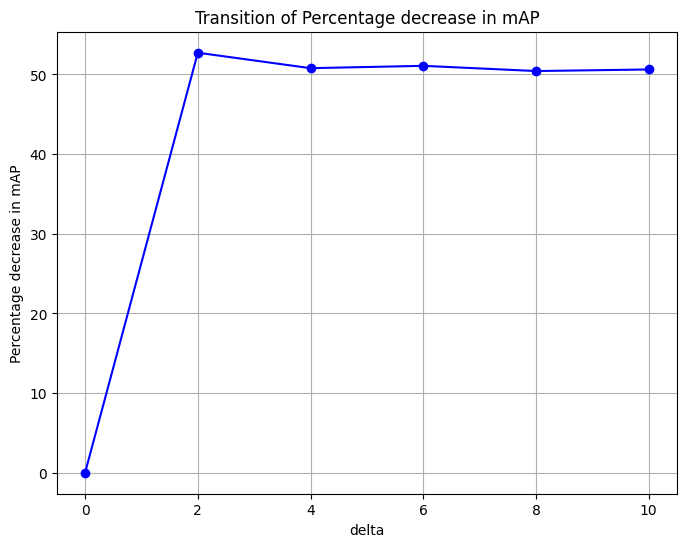

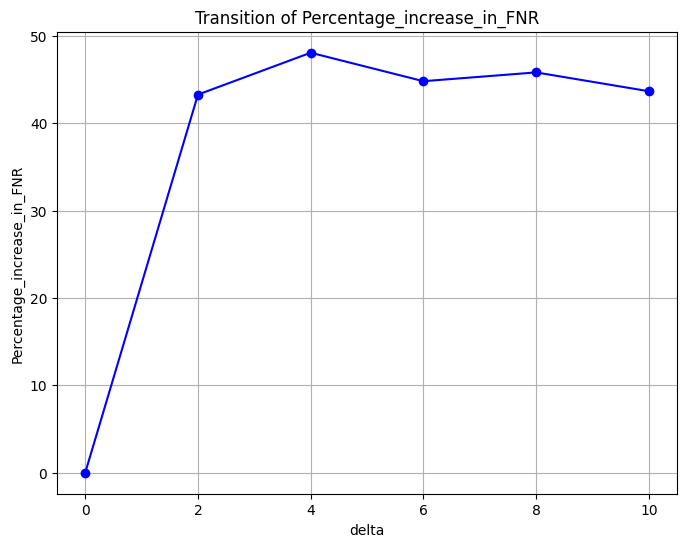

In [22]:
#########################################
# area:entory point
# do not edit
#########################################
if __name__ == '__main__':
    main()

In [23]:
#########################################
# area:license attribute set
# should edit
#########################################
ait_owner='AIST'
ait_creation_year='2025'

In [24]:
#########################################
# area:prepare deproy
# do not edit
#########################################

if not is_ait_launch:
    from ait_sdk.deploy import prepare_deploy
    from ait_sdk.license.license_generator import LicenseGenerator
    
    current_dir = %pwd
    prepare_deploy(ait_sdk_name, current_dir, requirements_path)
    
    # output License.txt
    license_generator = LicenseGenerator()
    license_generator.write('../top_dir/LICENSE.txt', ait_creation_year, ait_owner)
